In [1]:
import torch
import networkx as nx
import numpy as np
from collections import Counter

# Get the karate club example graph

In [2]:
G = nx.karate_club_graph()

## Auxiliary functions to help spidering process

In [3]:
def merge_dols(list_of_dicts):
    """
    Marge a list of dictionaries of lists.
    
    Args:
    - list_of_dicts (list) - List containing a set of dictionaries to merge.
        Each dictionary value should be list-type.
        
    Returns:
    - A dictionary where the unique values for each key have merged. 
    """
    # Get the first dictionary
    base_dict = list_of_dicts.pop()
    
    # Placeholder for empty list
    no = []
    
    # Loop through all of the remaining dictionaries in the list
    while len(list_of_dicts) > 0:
        
        # Get the next new dictionary
        new_dict = list_of_dicts.pop()
        
        # Extract all unique keys from the two dictionaries
        keys = set(base_dict).union(new_dict)
        
        # Merge in the new items for each key uniquely
        base_dict = dict((k, list(set(base_dict.get(k, no) + new_dict.get(k, no)))) for k in keys)
        
    # Return the final merged dictionary
    return base_dict

def flatten(l):
    """
    Flatten a list of lists one level.
    
    Args:
    - l (list) - List of lists
    
    Returns:
    - A flattened list.
    """
    return [item for sublist in l for item in sublist]

## Function to spider out from focal nodes

In [12]:
def spider_nodes(nodes, graph, neighborhood_size):
    """
    Spider out from a set of base nodes to return a fixed-sized neighborhood.
    
    Args:
    - nodes (list) - List of all nodes from which to spider out.
    - graph (networkx.Graph) - Graph of the full covalent structure.
    - neighborhood_size (int) - Size of neighborhood to be returned (including `nodes`).
    
    Returns:
    - Subgraph (networkx Graph object) containing the local neighborhood around the focal nodes
        specified in `nodes` argument.
    """
    
    # Get the successor trees for all of the focal nodes
    successors = merge_dols([dict(nx.bfs_successors(G, node)) for node in nodes])

    # Add the focal nodes to the nodeset
    nodeset = {*nodes}
    
    # Ensure that neighborhood size is large enough to fit focal nodes
    if len(nodeset) > neighborhood_size:
        raise(ValueError(f'Neighborhood size ({neighborhood_size}) not large enough to fit focal nodes ({len(nodeset)}).'))

    # Generate a path from the focal nodes
    path = nodeset

    # Keep increasing the neighborhood stepwise until the neighborhood size limit is reached
    # or there are no more nodes to add
    while len(nodeset) < neighborhood_size and path:

        # Get all node descendents (successors)
        node_dec = [successors[node] for node in path if node in successors]
        node_dec = flatten(node_dec)
        new_nodeset = set(node_dec)
        
        # Get the new set of nodes that may potentially be added to the neighborhood
        nodeset_union = nodeset.union(new_nodeset)
        path = new_nodeset.difference(nodeset)

        # Add new nodes to neighborhood if there is space
        if len(nodeset_union) <= neighborhood_size:
            nodeset = nodeset_union

        # Otherwise sample the new nodes weighted by the number of connections to nodes
        # already in the neighborhood
        else:
            edge_count = Counter(node_dec)
            sample_list = list(new_nodeset.difference(nodeset))
            p = np.array([edge_count[node] for node in sample_list])
            p = p / p.sum()
            size = neighborhood_size - len(nodeset)
            sample_set = set(np.random.choice(sample_list, size=size, replace=False, p=p))
            nodeset = nodeset.union(sample_set)
            
    return nodeset

In [ ]:
%%timeit
np.random.seed(0)
nodeset2 = spider_nodes([24, 25, 7, 8], G, 20)

In [17]:
nodeset2 = spider_nodes([24, 25, 7, 8], G, 20)
print(len(nodeset2))
print(nodeset2)

20
{0, 1, 2, 3, 32, 33, 7, 8, 13, 14, 18, 19, 20, 23, 24, 25, 27, 28, 30, 31}


In [18]:
H = G.subgraph(nodeset2)

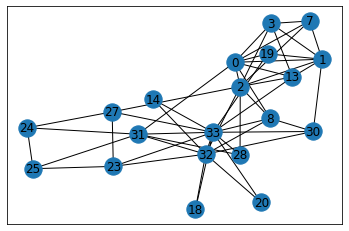

In [19]:
nx.draw_networkx(H, with_labels=True)

# Tests

In [16]:
# Test merge_dols
dict1 = {
    1: [2, 3],
    2: [4, 5],
}

dict2 = {
    2: [4, 5, 6],
    6: [7]
}

manual_combine = {
    1: [2, 3],
    2: [4, 5, 6],
    6: [7]
}

out_dict = merge_dols([dict1, dict2])

assert manual_combine == out_dict


# Test flatten
lols = [[1, 2, 3], [4, 5, 6]]
assert flatten(lols) == [1, 2, 3, 4, 5, 6]

# Only flattens one level
lols = [[1, 2, 3], [4, 5, 6, [7, 8]]]
assert flatten(lols) == [1, 2, 3, 4, 5, 6, [7, 8]]


# Test spider
np.random.seed(0)
nodeset = spider_nodes([24, 25, 7, 8], G, 20)
assert len(nodeset) == 20

np.random.seed(0)
nodeset = spider_nodes([24, 25, 7, 8], G, 30)
assert len(nodeset) == 30

# Test beyond number of nodes in graph
np.random.seed(0)
nodeset = spider_nodes([24, 25, 7, 8], G, 40)
assert len(nodeset) == 34